In [1]:
from echopype.convert import Convert
from echopype import Process
import glob
import random
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np

from os import path
import os


from echopy.processing import mask_seabed as  maskSB
from echopy.processing import mask_impulse as mIN
from echopy.processing import mask_shoals as mSH



from glider_azfp import load_glider, merge_glider_AZFP

In [2]:
# load in the glider data
# get from erddap first time, then save locally

gdata_local = './glider_data/'

gdata_id = 'ru32-20190102T1317-profile-sci-rt'

if path.exists('./glider_data/'+ gdata_id + '.nc'):
    
    gl = xr.open_dataset(gdata_local + gdata_id + '.nc')
    
else:

    gl = load_glider(dataset_id = gdata_id)
    
    if ~path.isdir(gdata_local):
        os.mkdir(gdata_local)
    
    gl.to_netcdf(gdata_local + gdata_id + '.nc')
    

gl

<xarray.Dataset>
Dimensions:                  (profile: 712, time: 113708)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-02T13:28:23.977110...
    latitude                 (time) float64 ...
    longitude                (time) float64 ...
    depth                    (time) float32 ...
Dimensions without coordinates: profile
Data variables:
    profile_id               (profile) float64 ...
    rowSize                  (profile) int32 ...
    trajectory               (time) object ...
    source_file              (time) object ...
    backscatter_coefficient  (time) float32 ...
    cdom                     (time) float32 ...
    chlorophyll_a            (time) float32 ...
    conductivity             (time) float32 ...
    crs                      (time) float64 ...
    ctd41cp_timestamp        (time) datetime64[ns] ...
    density                  (time) float32 ...
    flbbcd_timestamp         (time) datetime64[ns] ...
    instrument_azfp          (time) float64 ...
    instrument_ctd           (time) float64 ...
    instrument_flbbcd        (time) float64 ...
    m_pitch                  (time) float32 ...
    m_roll                   (time) float32 ...
    platform                 (time) float64 ...
    potential_temperature    (time) float32 ...
    pressure                 (time) float32 ...
    profile_lat              (time) float64 ...
    profile_lon              (time) float64 ...
    profile_time             (time) datetime64[ns] ...
    salinity                 (time) float32 ...
    sci_azfp_file_offset     (time) float32 ...
    sci_azfp_pause_signal    (time) float32 ...
    sci_azfp_run_state       (time) float32 ...
    sci_m_disk_free          (time) float32 ...
    sci_m_present_time       (time) datetime64[ns] ...
    sci_water_pressure       (time) float32 ...
    sound_speed              (time) float32 ...
    temperature              (time) float32 ...
    bottom_depth             (time) float32 ...
Attributes:
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Deployed by Schuyler Nardelli and Nicole...
    contributor_name:                Oscar Schofield,Deborah Steinberg,Schuyl...
    contributor_role:                Principal Investigator,Principal Investi...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    creator_email:                   kerfoot@marine.rutgers.edu
    creator_institution:             Rutgers University
    creator_name:                    John Kerfoot
    creator_type:                    person
    creator_url:                     https://rucool.marine.rutgers.edu
    date_created:                    2019-02-11T16:31:58Z
    date_issued:                     2019-02-11T16:31:58Z
    date_modified:                   2019-02-11T16:31:58Z
    defaultGraphQuery:               temperature,depth,time&time>=max(time)-1...
    deployment_id:                   555
    deployment_name:                 ru32-20190102T1317
    Easternmost_Easting:             -64.00858744126144
    featureType:                     Profile
    geospatial_bounds:               POLYGON ((-64.86942438308976 -64.0560274...
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_max:              -64.80610558179691
    geospatial_lat_min:              -64.8726387254351
    geospatial_lat_resolution:       0.00001 degree
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -64.00858744126144
    geospatial_lon_min:              -64.18408172522112
    geospatial_lon_resolution:       0.00001 degree
    geospatial_lon_units:            degrees_east
    geospatial_verical_resolution:   1
    geospatial_vertical_max:         595.7142
    geospatial_vertical_min:         0.009902111
    geospatial_vertical_positive:    down
    geospatial_vertical_units:       m
    history:                         2019-02-11T16:

# load an AZFP file

you'd want to build the loop below here

In [4]:
path_to_raw = './data/'

# alternativly, pick a random file
all_files = glob.glob(path_to_raw+'*.01A')
# a random file from the list (got to remove path and extention)
fname = random.choice(all_files)[7:-4]

# path to the 'fake' calibration file
calib_file = './data/NLB_test.XML'

print('random file used:')
print(fname + '.01A')

random file used:
19010503.01A


In [19]:

# fname = '19011711'
# fname = '19011717'
# fname = '19011709' #decent swarm, maybe bottom reflection?


# converts the raw AZFP data
# we are 'tricking' echopype with a fake .XML file
# the real files fail because there is no temperature data
# edit the './data/' parts so the path works for where you put the files
data_tmp = Convert(path_to_raw + fname + '.01A', calib_file)


# place to save processed files
savedir = './data_netcdfs/'

# converts to a netcdf we can use with xarray
data_tmp.raw2nc(save_path = savedir )


# read the converted data 

nc_path = savedir + fname + '.nc'

# process so you can get calibrated, clean, data 

ed = Process(nc_path)   # create a processing object

# need to figure out how much it matter that these vary a lot

ed.temperature = gl.potential_temperature.mean().values  
ed.salinity = gl.salinity.mean().values     
ed.pressure = gl.pressure.mean().values     # pressure in dbar
ed.recalculate_environment()  # recalculate related parameters

ed.calibrate()           # Sv

# lets remove the first few bins with ringdown?
ed.Sv.Sv[:,:,:100] = np.NaN

ed.remove_noise(SNR=2)        # denoise, this is adaptive! will change with the file! NOT WORKING NOW!



azfp = ed.Sv_clean


09:48:26 converting file 19010503.01A with NLB_test.XML, time of first ping 2019-Jan-05 03:00:00
          ... this file has already been converted to .nc, conversion not executed.
Initialize using average temperature recorded by instrument
09:48:26  calibrating data in ./data_netcdfs/19010503.nc
09:48:27  Remove noise from Sv stored in memory.


In [21]:

# merge the glider and azfp data

ds = merge_glider_AZFP( gl, azfp, )

ds

<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 143, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-05T03:00:00 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
    bin_depths                (ping_time, range_bin) float64 313.5 ... 439.3
    distance                  (ping_time) float64 0.0 0.6687 ... 94.28 94.95
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 nan ....
    noise_est_range_bin_size  (frequency, ping_time) float64 5.017 ... 5.017
    range                     (frequency, range_bin, ping_time) float64 0.363...
    potential_temperature     (ping_time) float64 1.204 1.203 ... 1.256 1.258
    salinity                  (ping_time) float64 34.61 34.61 ... 34.62 34.63
    chlorophyll_a             (ping_time) float64 0.05894 0.05751 ... 0.05695
    m_pitch                   (ping_time) float64 -0.377 -0.377 ... -0.2662
    m_roll                    (ping_time) float64 -0.03857 -0.03853 ... -0.03268
    bottom_depth              (ping_time) float64 418.7 418.7 ... 442.3 442.3
    latitude                  (ping_time) float64 -64.83 -64.83 ... -64.83
    longitude                 (ping_time) float64 -64.15 -64.15 ... -64.15
    depth                     (ping_time) float64 313.1 313.5 ... 365.9 366.3

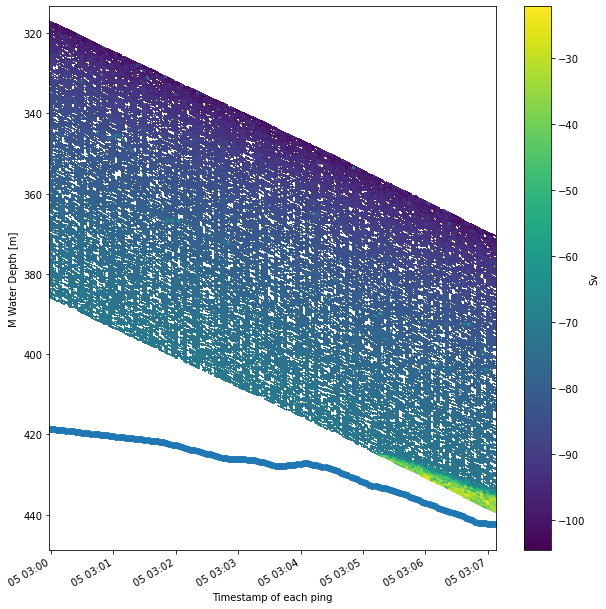

In [55]:

plt.figure(figsize=(10,10))
ds.Sv[2,:,:].plot(x="ping_time", y="bin_depths", yincrease=False)
ds.bottom_depth.plot(marker='o', ls='')


# processing with echopy

try some:
1. seabed masking
1. impluse noise removal
1. swarm detection

In [46]:

sf_mask = np.empty_like(ds.Sv)

j = 0
for f in ds.frequency:
    sf_mask[j,:,:] = maskSB.ariza(ds.Sv.sel(frequency=f).data.T, ds.range[0,:,0].data,
                      dc=3).T
    j+=1
    
seafloor_mask = np.any(sf_mask, axis=0)

ds.update({'seafloor_mask': (('ping_time', 'range_bin'), seafloor_mask)})

<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 143, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-05T03:00:00 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
    bin_depths                (ping_time, range_bin) float64 313.5 ... 439.3
    distance                  (ping_time) float64 0.0 0.6687 ... 94.28 94.95
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 nan ....
    noise_est_range_bin_size  (frequency, ping_time) float64 5.017 ... 5.017
    range                     (frequency, range_bin, ping_time) float64 0.363...
    potential_temperature     (ping_time) float64 1.204 1.203 ... 1.256 1.258
    salinity                  (ping_time) float64 34.61 34.61 ... 34.62 34.63
    chlorophyll_a             (ping_time) float64 0.05894 0.05751 ... 0.05695
    m_pitch                   (ping_time) float64 -0.377 -0.377 ... -0.2662
    m_roll                    (ping_time) float64 -0.03857 -0.03853 ... -0.03268
    bottom_depth              (ping_time) float64 418.7 418.7 ... 442.3 442.3
    latitude                  (ping_time) float64 -64.83 -64.83 ... -64.83
    longitude                 (ping_time) float64 -64.15 -64.15 ... -64.15
    depth                     (ping_time) float64 313.1 313.5 ... 365.9 366.3
    seafloor_mask             (ping_time, range_bin) bool False False ... True

<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 143, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-05T03:00:00 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
    bin_depths                (ping_time, range_bin) float64 313.5 ... 439.3
    distance                  (ping_time) float64 0.0 0.6687 ... 94.28 94.95
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 nan ....
    noise_est_range_bin_size  (frequency, ping_time) float64 5.017 ... 5.017
    range                     (frequency, range_bin, ping_time) float64 0.363...
    potential_temperature     (ping_time) float64 1.204 1.203 ... 1.256 1.258
    salinity                  (ping_time) float64 34.61 34.61 ... 34.62 34.63
    chlorophyll_a             (ping_time) float64 0.05894 0.05751 ... 0.05695
    m_pitch                   (ping_time) float64 -0.377 -0.377 ... -0.2662
    m_roll                    (ping_time) float64 -0.03857 -0.03853 ... -0.03268
    bottom_depth              (ping_time) float64 418.7 418.7 ... 442.3 442.3
    latitude                  (ping_time) float64 -64.83 -64.83 ... -64.83
    longitude                 (ping_time) float64 -64.15 -64.15 ... -64.15
    depth                     (ping_time) float64 313.1 313.5 ... 365.9 366.3
    seafloor_mask             (ping_time, range_bin) bool False False ... True
    swarm_mask                (frequency, ping_time, range_bin) float64 0.0 ....

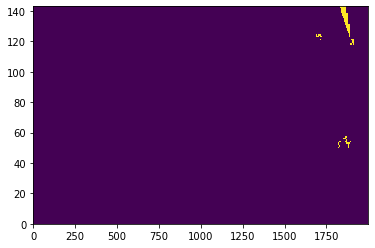

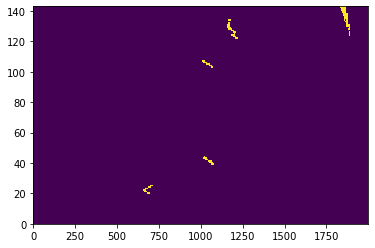

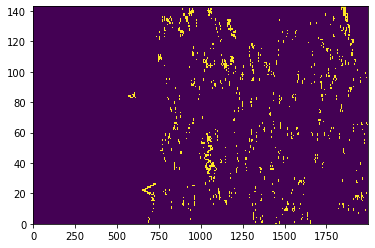

In [59]:
swarm_mask = np.empty_like(ds.Sv)

j = 0
for f in ds.frequency:
    swarm_mask[j,:,:] = mSH.echoview(ds.Sv.sel(frequency=f).where(~ds.seafloor_mask).data.T,
                                    np.arange( len(ds.Sv.range_bin )+1),
                                    np.arange(len(ds.Sv.ping_time)+1),
                                    thr=-85,
                                    mincan=(5, 5),
                                    maxlink=(30, 2),
                                    minsho=(30, 2) )[0].T
    
#     plt.figure()
#     plt.pcolormesh(swarm_mask[j,:,:])
    j+=1
                                     
ds.update({'swarm_mask': (('frequency','ping_time', 'range_bin'),swarm_mask)})                                                                         

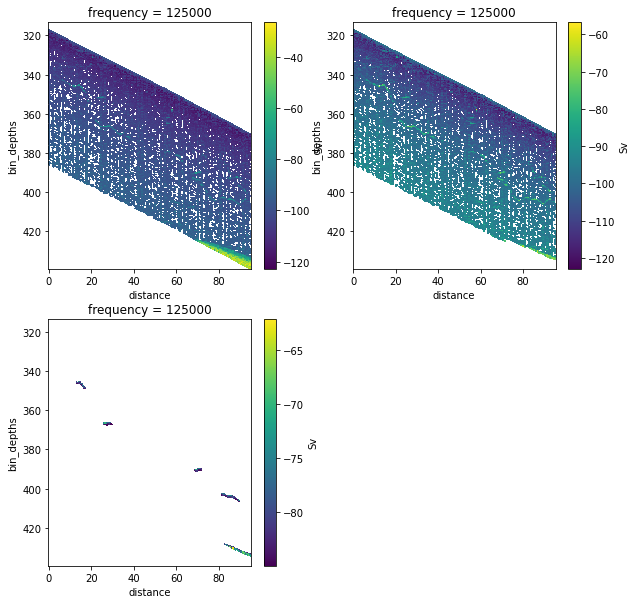

In [63]:
plt.figure(figsize=(10,10))

f = ds.frequency[1]

plt.subplot(221)
ds.Sv.sel(frequency =f ).plot(x="distance", 
                                            y="bin_depths", yincrease=False)

plt.subplot(222)

ds.Sv.sel(frequency=f).where(~ds.seafloor_mask).plot(x="distance", 
                                            y="bin_depths", yincrease=False)

plt.subplot(223)

ds.Sv.sel(frequency=f).where(ds.swarm_mask.sel(frequency=f)
                            ).plot(x="distance", 
                                            y="bin_depths", yincrease=False)

# ds.bottom_depth.plot(marker='o', ls='')

<ipython-input-51-f5d3ad563b44>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh( ds.ping_time, ds.range[0,:,0], sb)
<ipython-input-51-f5d3ad563b44>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.ping_time, ds.range[0,:,0],ds.Sv[0,:,:].T.data )


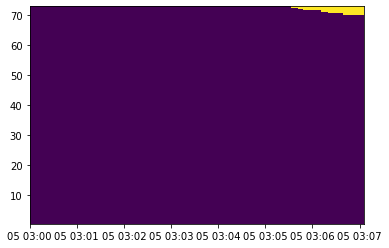

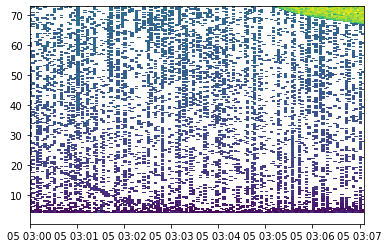

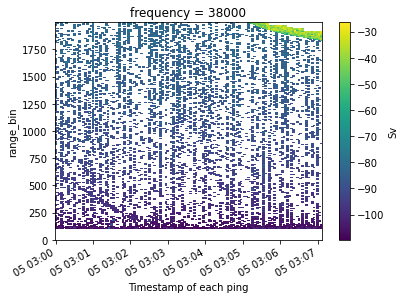

In [51]:
# sb = mask_seabed.deltaSv(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data,
#                       r0=10, thr=-20)

# sb = mask_seabed.maxSv(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data)

sb = maskSB.ariza(ds.Sv[1,:,:].data.T, ds.range[0,:,0].data,
                      dc=3)

# sb = mask_seabed.experimental(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data,
#                       )

plt.pcolormesh( ds.ping_time, ds.range[0,:,0], sb)

plt.figure()
plt.pcolormesh(ds.ping_time, ds.range[0,:,0],ds.Sv[0,:,:].T.data )

plt.figure()

ds.Sv[0,:,:].where(sb.T==0).plot(x="ping_time")

<ipython-input-34-5ea7599ac88d>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.ping_time, ds.range[0,:,0], shoal[0] )


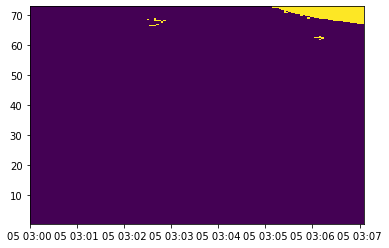

In [34]:
# look for swarms:

# shoal = mSH.weill(ds.Sv[0,:,:].data.T)

shoal = mSH.echoview(ds.Sv[0,:,:].data.T,
    np.arange( len(ds.Sv.range_bin )+1),
    np.arange(len(ds.Sv.ping_time)+1),
    thr=-85,
    mincan=(5, 5),
    maxlink=(30, 2),
    minsho=(30, 2),
)

# shoal = mSH.echoview(ds.Sv[0,:,:].data.T,
#     ds.range[0,:,0].values,
#     ds.distance.values,
#     thr=-85,
#     mincan=(3, 10),
#     maxlink=(3, 15),
#     minsho=(3, 15),
# )


plt.figure()
plt.pcolormesh(ds.ping_time, ds.range[0,:,0], shoal[0] )